In [1]:
%matplotlib notebook
import os
import numpy as np
import torch
from torch import nn
import my_nntools as nt
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt

import itertools

import models as models
from utils import *

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
dataset_root_dir="./datasets/ukiyoe2photo/"

In [4]:
# Dataset loader
train_set = ImageDataset(dataset_root_dir, image_size=128, unaligned=True, mode='train')
test_set = ImageDataset(dataset_root_dir, image_size=128, unaligned=True, mode='test')

In [5]:
class NNClassifier(nt.NeuralNetwork):
    def __init__(self):
        super(NNClassifier, self).__init__()
        self.MSE_Loss = nn.MSELoss()
        self.L1_Loss = nn.L1Loss()
       
    def criterion_GAN(self, y, d):
        return self.MSE_Loss(y, d)
    def criterion_cycle(self, y, d):
        return self.L1_Loss(y, d)*5
    def criterion_identity(self, y, d):
        return self.L1_Loss(y, d)*10
    
class C_GAN(NNClassifier):
    def __init__(self, fine_tuning=True):
        super(C_GAN, self).__init__()
        
        self.G_A2B = models.Generator(3, 3)
        self.G_B2A = models.Generator(3, 3)
        self.D_A = models.Discriminator(3)
        self.D_B = models.Discriminator(3)
        
        self.G_A2B.apply(init_parameters)
        self.G_A2B.apply(init_parameters)
        self.D_A.apply(init_parameters)
        self.D_B.apply(init_parameters)
    
        self.fake_a_buffer = ReplayBuffer()
        self.fake_b_buffer = ReplayBuffer()
    
    def forward(self, real_a, real_b):        
        fake_b = 0.5*(self.G_A2B(real_a) + 1.0)
        fake_a = 0.5*(self.G_B2A(real_b) + 1.0)
        
        return fake_a,fake_b

In [6]:
class ClassificationStatsManager(nt.StatsManager):
    def __init__(self):
        super(ClassificationStatsManager, self).__init__()
        
    def init(self):
        super(ClassificationStatsManager, self).init()
        self.running_loss_G = 0
        self.running_loss_D_A = 0
        self.running_loss_D_B = 0
    
    def accumulate(self, loss_G, loss_D_A, loss_D_B):
        super(ClassificationStatsManager, self).accumulate(loss_G, loss_D_A, loss_D_B)
        self.running_loss_G += loss_G
        self.running_loss_D_A += loss_D_A
        self.running_loss_D_B += loss_D_B

    def summarize(self):
        """Compute statistics based on accumulated ones"""
        loss_G = self.running_loss_G / self.number_update 
        loss_D_A = self.running_loss_D_A / self.number_update 
        loss_D_B = self.running_loss_D_B / self.number_update
        return { 'G loss' : loss_G, 'D_A loss' : loss_D_A, 'D_B loss' : loss_D_B}

In [7]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [8]:
def plot(exp, fig, axes, A, B, visu_rate=2):
    if exp.epoch % visu_rate != 0:
        return
    with torch.no_grad():
        fake_a,fake_b = exp.net(A[np.newaxis].to(exp.net.device),B[np.newaxis].to(exp.net.device))
    
    axes[0][0].clear()
    axes[0][1].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    myimshow(A, ax=axes[0][0])
    axes[0][0].set_title('real A')
    
    myimshow(fake_b[0], ax=axes[0][1])
    axes[0][1].set_title('fake B')
    
    myimshow(B, ax=axes[1][0])
    axes[1][0].set_title('real B')
    
    myimshow(fake_a[0], ax=axes[1][1])
    axes[1][1].set_title('fake A')
    
    plt.tight_layout()
    fig.canvas.draw()

In [9]:
lr = 1e-3
net = C_GAN()
net = net.to(device)

optimizer_G = torch.optim.Adam(itertools.chain(net.G_A2B.parameters(), 
                                               net.G_B2A.parameters()), lr=lr)
optimizer_D_A = torch.optim.Adam(net.D_A.parameters(), lr=lr)
optimizer_D_B = torch.optim.Adam(net.D_B.parameters(), lr=lr)

stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(net, train_set, test_set, 
                     optimizer_G, optimizer_D_A,optimizer_D_B,
                     stats_manager, output_dir="CGAN",batch_size=1)

<IPython.core.display.Javascript object>


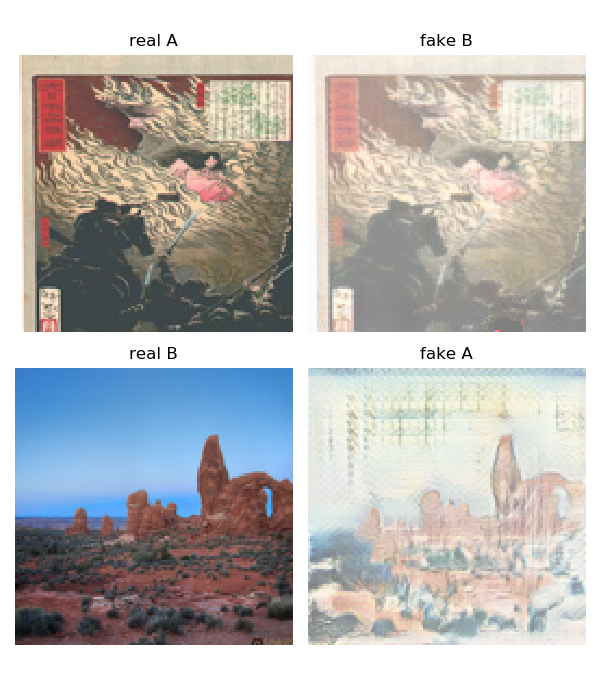

Start/Continue training from epoch 3
Epoch 4 [G loss: 6.6349, D_A loss: 0.0674, D_B loss: 0.0977] (Time: 1534.17s)
Epoch 5 [G loss: 6.3809, D_A loss: 0.0404, D_B loss: 0.0932] (Time: 1409.09s)
Epoch 6 [G loss: 5.8715, D_A loss: 0.1220, D_B loss: 0.0980] (Time: 1320.98s)
Epoch 7 [G loss: 5.3549, D_A loss: 0.2060, D_B loss: 0.1072] (Time: 1319.91s)
Epoch 8 [G loss: 5.2376, D_A loss: 0.2002, D_B loss: 0.0883] (Time: 1297.07s)
Epoch 9 [G loss: 5.0693, D_A loss: 0.1838, D_B loss: 0.0951] (Time: 1288.45s)
Epoch 10 [G loss: 5.1604, D_A loss: 0.1641, D_B loss: 0.0817] (Time: 1278.34s)
Epoch 11 [G loss: 4.9399, D_A loss: 0.1710, D_B loss: 0.0945] (Time: 1276.32s)
Epoch 12 [G loss: 4.9539, D_A loss: 0.1594, D_B loss: 0.0757] (Time: 1286.22s)
Epoch 13 [G loss: 4.8464, D_A loss: 0.1575, D_B loss: 0.0675] (Time: 1260.85s)
Epoch 14 [G loss: 4.7606, D_A loss: 0.1548, D_B loss: 0.0681] (Time: 1334.95s)
Epoch 15 [G loss: 4.6950, D_A loss: 0.1499, D_B loss: 0.0388] (Time: 1258.81s)
Epoch 16 [G loss: 4.6

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(6,7))
val_a,val_b=test_set[10]
exp1.run(num_epochs=100, plot=lambda exp: plot(exp, fig=fig, axes=axes, A=val_a, B=val_b))

In [ ]:
def GetResults(net,test_set):
    test_loader = td.DataLoader(test_set, batch_size=1, shuffle=False, drop_last=True, pin_memory=True)
    net.eval()
    
    # Create output dirs if they don't exist
    if not os.path.exists('output/A'):
        os.makedirs('output/A')
    if not os.path.exists('output/B'):
        os.makedirs('output/B')
        
    with torch.no_grad():
        i=0
        for real_a,real_b in test_loader:
            real_a, real_b = real_a.to(net.device), real_b.to(net.device)
            fake_a,fake_b = net(real_a, real_b)
            # Save image files
            tv.utils.save_image(fake_a, 'output/A/%04d.png' % (i+1))
            tv.utils.save_image(fake_b, 'output/B/%04d.png' % (i+1))
            i+=1
            
            print('Generated images %04d of %04d' % (i, len(test_loader)))

In [ ]:
GetResults(net,test_set)